# Buoy data from Dec 6-13, 2023

There are three sources of the buoy data
- hollywood beach (just north of south beach) for met data (air/water temp etc.)
- RSMAS U.Miami (viginia key just south of south beach) (wave data)
- tides from ndbc website as they aren't in either file (tide data)

In this notebook we 
- read in buoy data
- remove bad data points and interpolate across the missing data
- interpolate the different datasets all onto the same time coordinate system
- combine the data into a single xarray dataset
- plot the data
- create a new dataset with 1-second sampling
- interpolate the data onto the new sampling
- output the data


In [1]:
import pandas as pd
import warnings
import xarray as xr
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt


astation_hollywood = '41122' #hollywood beach (just north of south beach)
astation_virkey='VAKF1'
astation_virkey2 = '8723214' #rsmas buoy

#PICK TIME PERIOD HERE BEFORE RUNNING ALSO CHECK FILE NAMES BELOW
# Get today's date
date_start = datetime.today()
date_end = date_start - timedelta(days=3)
#december
date_start = datetime(2023, 12, 6)
date_end = datetime(2023, 12, 13)

# Format the date as text
start_text = date_start.strftime("%Y%m%d")
end_text = date_end.strftime("%Y%m%d")

#45 day nrt data from noaa site
fname_holly = 'https://www.ndbc.noaa.gov/data/realtime2/'+astation_hollywood+'.txt'
fname_vkey = 'https://www.ndbc.noaa.gov/data/realtime2/'+astation_virkey+'.txt'
fname_vkey_tide = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date='+end_text+'&end_date='+start_text+'&datum=MLLW&station='+astation_virkey2+'&time_zone=GMT&units=english&interval=&format=csv'

#historical data
fname_holly = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=41122h2023.txt.gz&dir=data/historical/stdmet/'
fname_vkey = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=vakf1h2023.txt.gz&dir=data/historical/stdmet/'
fname_vkey_tide = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date='+end_text+'&end_date='+start_text+'&datum=MLLW&station='+astation_virkey2+'&time_zone=GMT&units=english&interval=&format=csv'
fname_vkey_level = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=water_level&application=NOS.COOPS.TAC.WL&begin_date='+end_text+'&end_date='+start_text+'&datum=MLLW&station='+astation_virkey2+'&time_zone=GMT&units=english&interval=&format=csv'

def remove_bad_data(data):
    data = data.where(data != 9999, np.nan)
    data = data.where(data != 999, np.nan)
    data = data.where(data != 99, np.nan)
    data = data.interpolate_na(dim="time", method="linear")
    return data

def get_buoy(fname): 
    df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
    df_buoy_units=df_buoy[:][0:1] #remove row that has units
    df_buoy=df_buoy[:][1:len(df_buoy)] #remove row that has units
    df_buoy.insert(0,'Year',df_buoy['#YY'])
    df_buoy.insert(1,'Month',df_buoy['MM'])
    df_buoy.insert(2,'Day',df_buoy['DD'])
    df_buoy.insert(2,'hour',df_buoy['hh'])
    df_buoy.insert(2,'minute',df_buoy['mm'])
    df_buoy.insert(0,'time',pd.to_datetime(df_buoy[list(df_buoy)[0:5]]))
    df_buoy=df_buoy.drop(columns={'Year','Month','minute','hour','Day','hh','mm','DD','MM','#YY'})
    df_buoy = df_buoy.set_index(['time'])
    df_buoy = df_buoy.astype('float64')
    ds_buoy = df_buoy.to_xarray()
    ds_buoy = ds_buoy.sortby(ds_buoy.time,ascending=True)
    #remove missing data points and interpoloate across missing data
    ds_buoy = remove_bad_data(ds_buoy)
    return ds_buoy

def get_buoy_tide(fname):
    fname_vkey_tide = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&'+'begin_date='+start_text+'&end_date='+end_text+'&datum=MLLW&station='+astation_virkey2+'&time_zone=GMT&units=english&interval=&format=csv'
    df_tide = pd.read_csv(fname_vkey_tide, delim_whitespace=False,parse_dates=True)
    df_tide.insert(0,'time',pd.to_datetime(df_tide['Date Time']))
    df_tide.insert(2,'tide_predicted',df_tide[' Prediction'])
    df_tide=df_tide.drop(columns={'Date Time',' Prediction'})
    df_tide = df_tide.set_index(['time'])
    ds_tide = df_tide.to_xarray()
    return ds_tide

In [2]:
#historical data
##YY MM DD hh mm WDIR WSPD GST WVHT DPD APD MWD PRES ATMP WTMP DEWP VIS TIDE
ds_holly = get_buoy(fname_holly)
ds_holly = ds_holly.sel(time=slice(start_text,end_text))
ds_key = get_buoy(fname_vkey)
ds_key = ds_key.sel(time=slice(start_text,end_text))
ds_key_tide = get_buoy_tide(fname_vkey_tide)
ds_tide = ds_key_tide.sel(time=slice(start_text,end_text))

In [3]:
#interpolate the hollywood & tide data onto the virginia key data times
ds_hollyi = ds_holly.interp(time=ds_key.time)
ds_buoy=ds_hollyi.copy()
ds_buoy['WDIR']=ds_key['WDIR']
ds_buoy['WSPD']=ds_key['WSPD']
ds_buoy['GST']=ds_key['GST']
ds_buoy['PRES']=ds_key['PRES']
ds_buoy['ATMP']=ds_key['ATMP']
ds_buoy['WTMP']=ds_key['WTMP']
ds_key_tidei = ds_key_tide.interp(time=ds_buoy.time)
ds_buoy['tide']=ds_key_tidei['tide_predicted']
ds_buoy = ds_buoy.drop_vars({'TIDE','DEWP','VIS'})

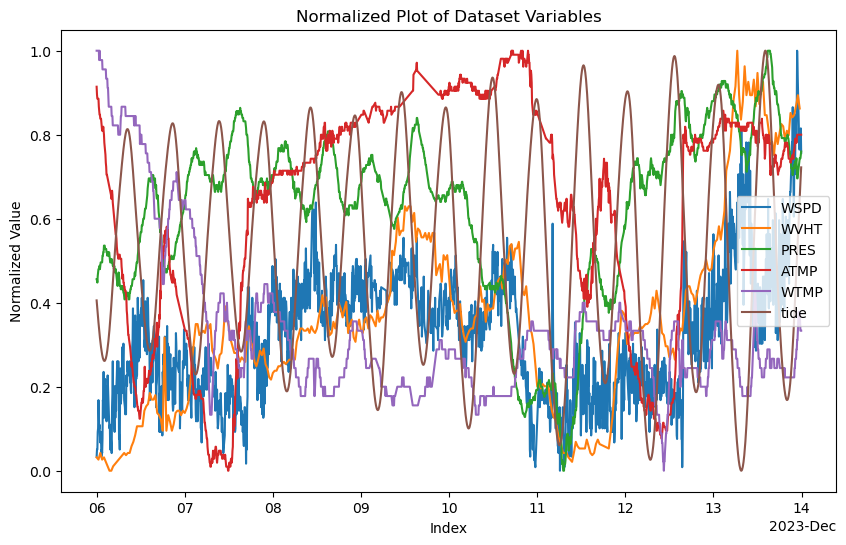

In [4]:
# Normalize each variable in the dataset and plot
def normalize(var):
    return (var - var.min()) / (var.max() - var.min())

# Create a plot for each variable
fig, ax = plt.subplots(figsize=(10, 6))

for var_name in ds_buoy.data_vars:
    if var_name=='DPD'or var_name=='WDIR' or var_name=='GST' or var_name=='APD' or var_name=='MWD':
        continue
    normalized_var = normalize(ds_buoy[var_name])
    normalized_var.plot(label=var_name, ax=ax)

# Add legend and labels
plt.title('Normalized Plot of Dataset Variables')
plt.ylabel('Normalized Value')
plt.xlabel('Index')
plt.legend()
#plt.savefig('./figures/buoy_data_all_dec2023')

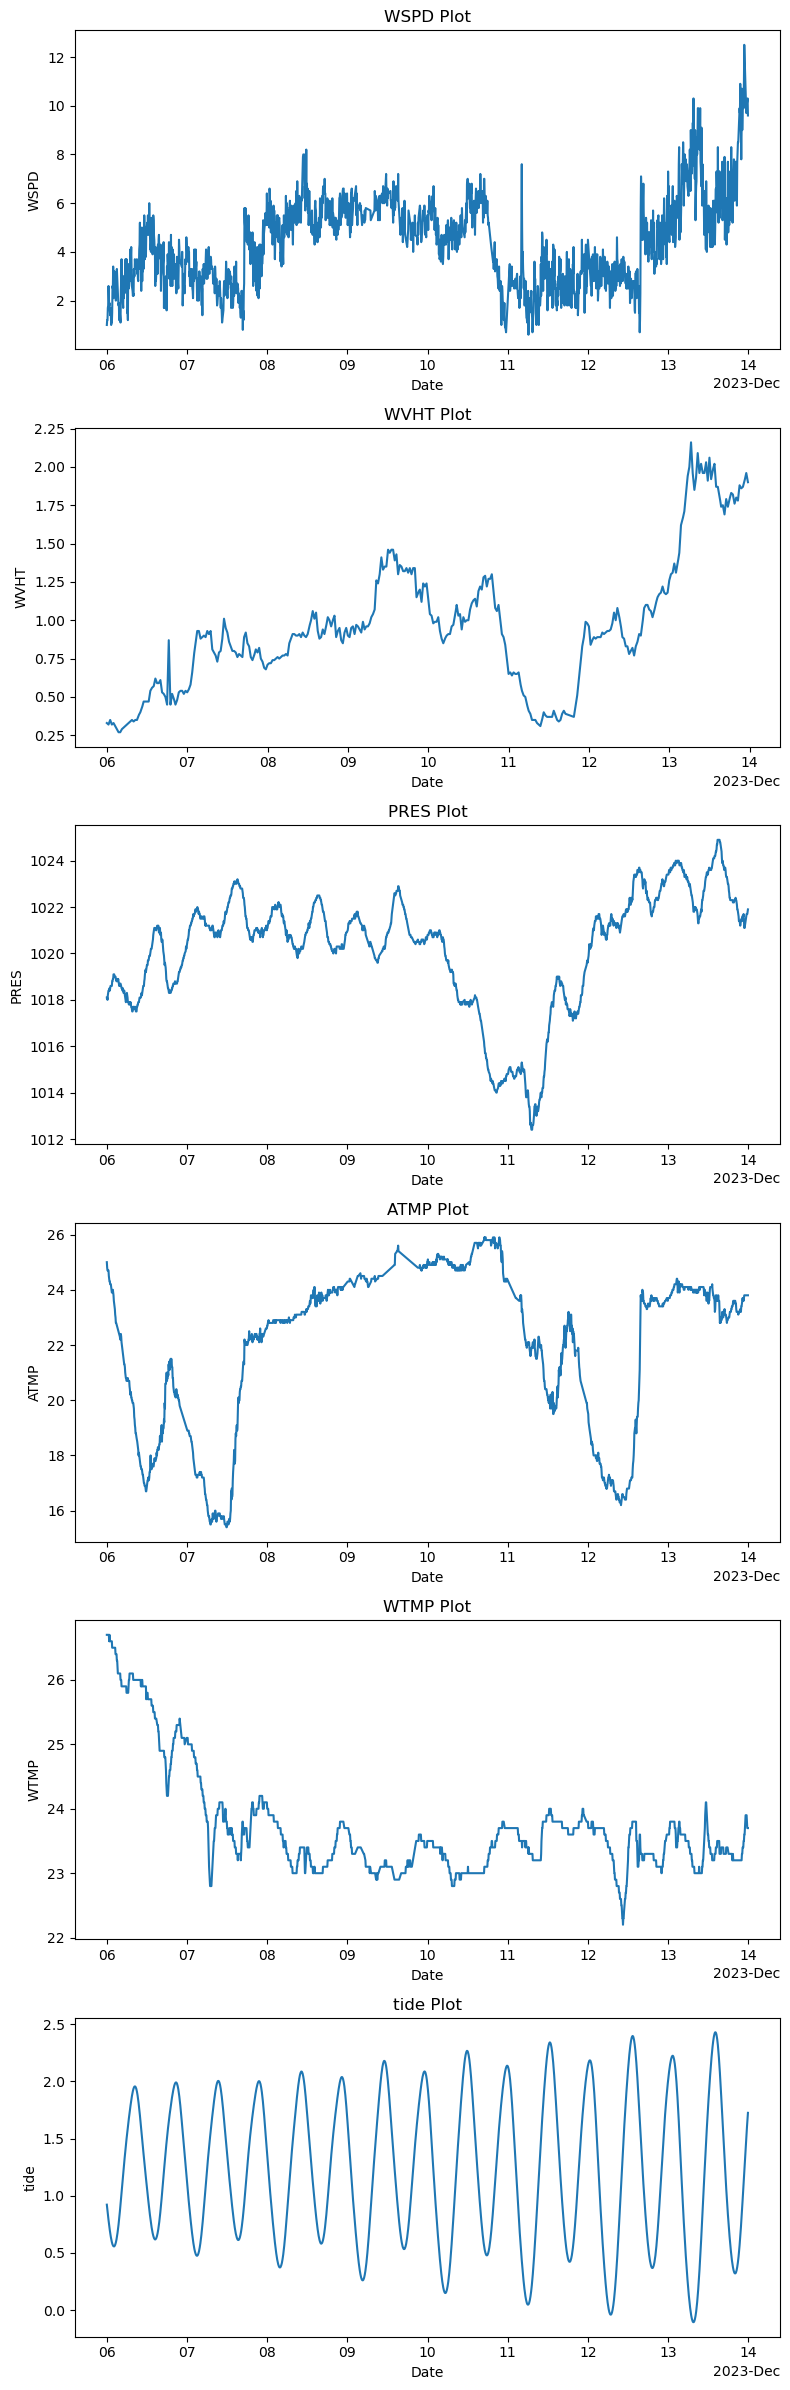

In [5]:
# Number of variables to plot
data = ds_buoy
num_vars = len(data.data_vars)
subs = num_vars-5

# Create a subplot for each variable
fig, axes = plt.subplots(nrows=subs, figsize=(8, 4 * subs))

# If there's only one variable, make axes a list to allow iteration
if num_vars == 1:
    axes = [axes]

# Loop through the variables and plot each on a separate subplot
ii=-1
for i, var_name in enumerate(data.data_vars):
    if var_name=='DPD'or var_name=='WDIR' or var_name=='GST' or var_name=='APD' or var_name=='MWD':
        continue
    ii=ii+1
    data[var_name].plot(ax=axes[ii])
    axes[ii].set_title(f"{var_name} Plot")  # Set title for each plot
    axes[ii].set_xlabel("Date")
    axes[ii].set_ylabel(var_name)

# Adjust layout
plt.tight_layout()

plt.savefig('./figures/buoy_data_all_subplots_dec2023')

In [6]:
#create fake data with 1 second data
time_range = pd.date_range(start=start_text, end=end_text, freq='S')
# Generate some example data (e.g., random data)
data = np.random.rand(len(time_range))
ds_wave = xr.Dataset({"wave": (["time"], data),},coords={"time": time_range,})
ds_wave

ds_buoy2 = ds_buoy.interp(time=ds_wave.time)

# Convert DataArray to DataFrame and SAVE to file
df = ds_buoy2.to_dataframe()
df.to_csv("./../buoy_data/buoy_data1sec_dec2023_all_variables.csv")
# Convert DataArray to DataFrame and SAVE to file
ds_buoy2=ds_buoy2.drop({'DPD','WDIR','GST','APD','MWD'})
df = ds_buoy2.to_dataframe()
df.to_csv("./../buoy_data/buoy_data1sec_dec2023_selected_variables.csv")